<a href="https://colab.research.google.com/github/surajjorwar/FitnessTracker/blob/main/Low_pass_Filter_%26_Principal_Component_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd '/content/drive/MyDrive/FitnessTracker/FitnessTracker/data-science-template-main/src/features/'

/content/drive/MyDrive/FitnessTracker/FitnessTracker/data-science-template-main/src/features


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from DataTransformation import LowPassFilter,PrincipalComponentAnalysis
from TemporalAbstraction import NumericalAbstraction


# Load data

In [3]:
df= pd.read_pickle('/content/drive/MyDrive/FitnessTracker/FitnessTracker/data-science-template-main/data/interim/02_outliers_removed_chauvenets.pkl')

In [6]:
predictor_columns = list(df.iloc[:,:6])

In [4]:
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"]= (20,5)
plt.rcParams["figure.dpi"]= 100
plt.rcParams["lines.linewidth"] = 2

# Dealing with missing values (imputation)


In [7]:
for col in predictor_columns:
  df[col] = df[col].interpolate()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9009 entries, 2019-01-11 15:08:05.200000 to 2019-01-20 17:33:27.800000
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   acc_x        9009 non-null   float64
 1   acc_y        9009 non-null   float64
 2   acc_z        9009 non-null   float64
 3   gyr_x        9009 non-null   float64
 4   gyr_y        9009 non-null   float64
 5   gyr_z        9009 non-null   float64
 6   participant  9009 non-null   object 
 7   label        9009 non-null   object 
 8   category     9009 non-null   object 
 9   set          9009 non-null   int64  
dtypes: float64(6), int64(1), object(3)
memory usage: 774.2+ KB


# Calculating set duration

<Axes: xlabel='epoch (ms)'>

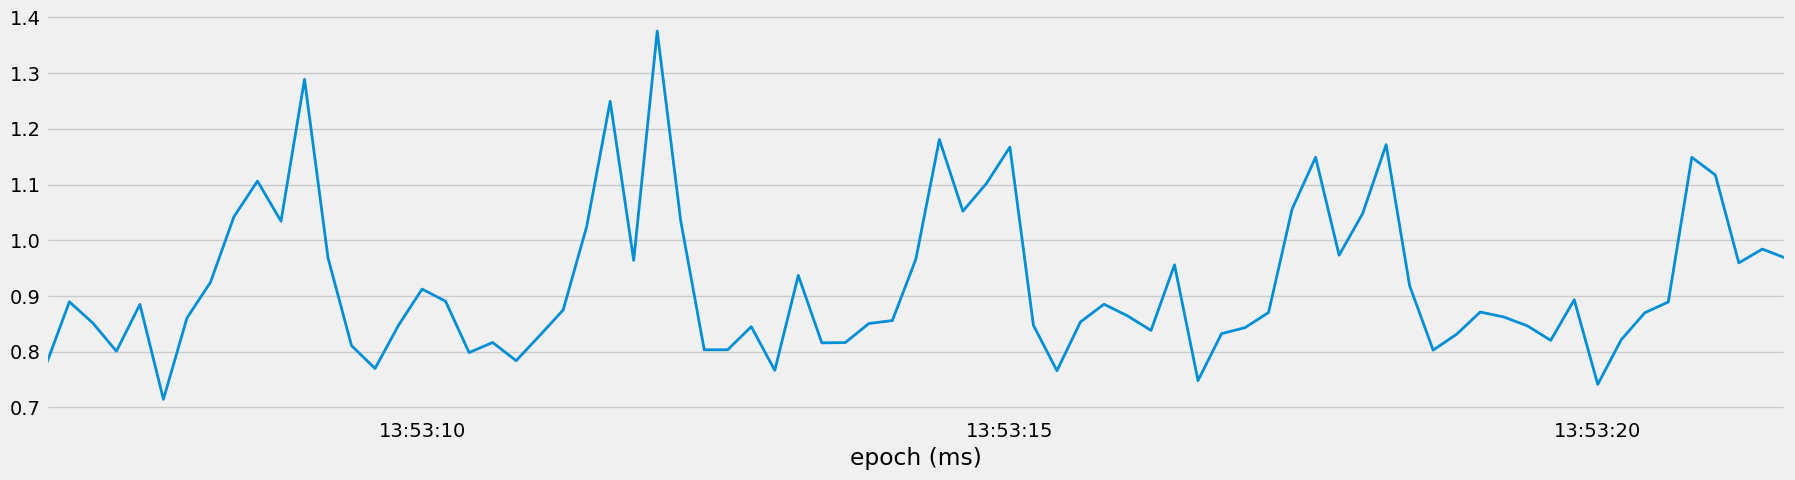

In [9]:
df[df['set']==22]["acc_y"].plot()

<Axes: xlabel='epoch (ms)'>

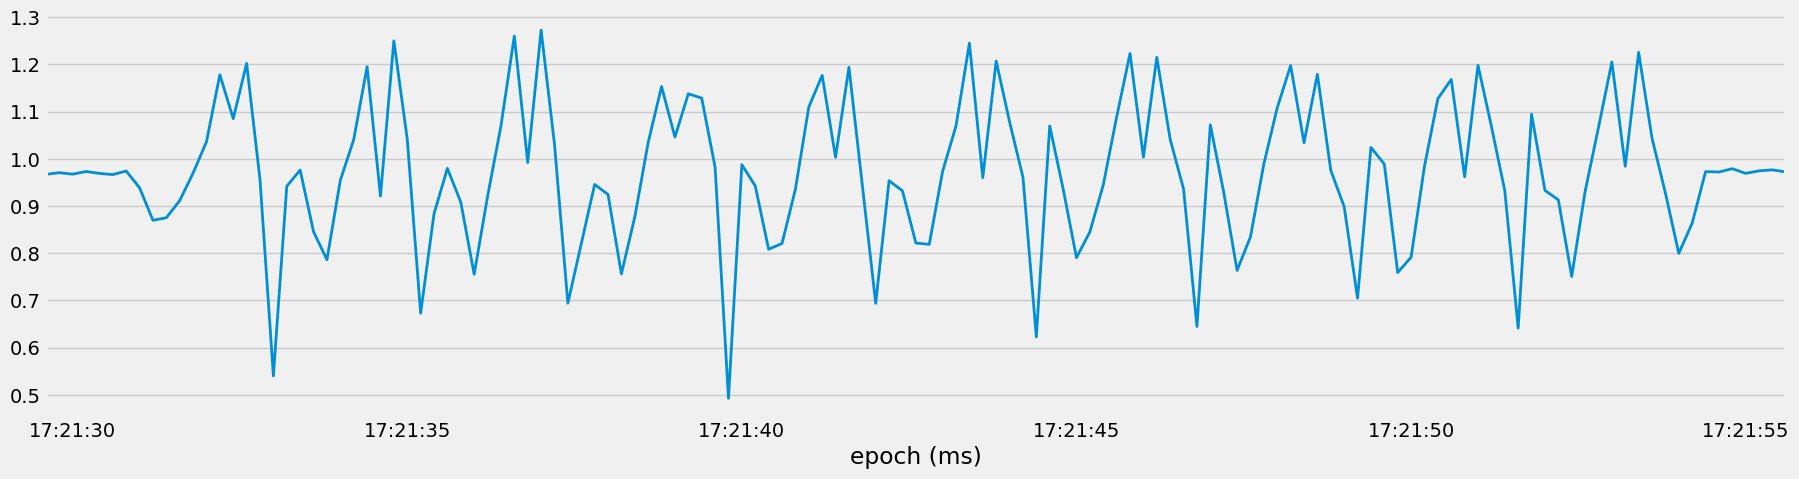

In [10]:
df[df['set']==50]["acc_y"].plot()

# Calculating set duration

In [11]:
for s in df['set'].unique():
  start = df[df['set']==s].index[0]
  stop = df[df['set']==s].index[-1]
  duration =   stop -start
  df.loc[(df['set']==s),"duration"] = duration.seconds

In [12]:
df.groupby(['category'])['duration'].mean()

category
heavy       14.743501
medium      24.942529
sitting     33.000000
standing    39.000000
Name: duration, dtype: float64

In [13]:
duration_df = df.groupby(['category'])['duration'].mean()

In [14]:
print('heavy',duration_df.iloc[0]/5)
print('medium',duration_df.iloc[1]/10 )

heavy 2.9487001733102254
medium 2.4942528735632186


# Butterworth lowpass filter

In [15]:
df_lowpass = df.copy()

dead


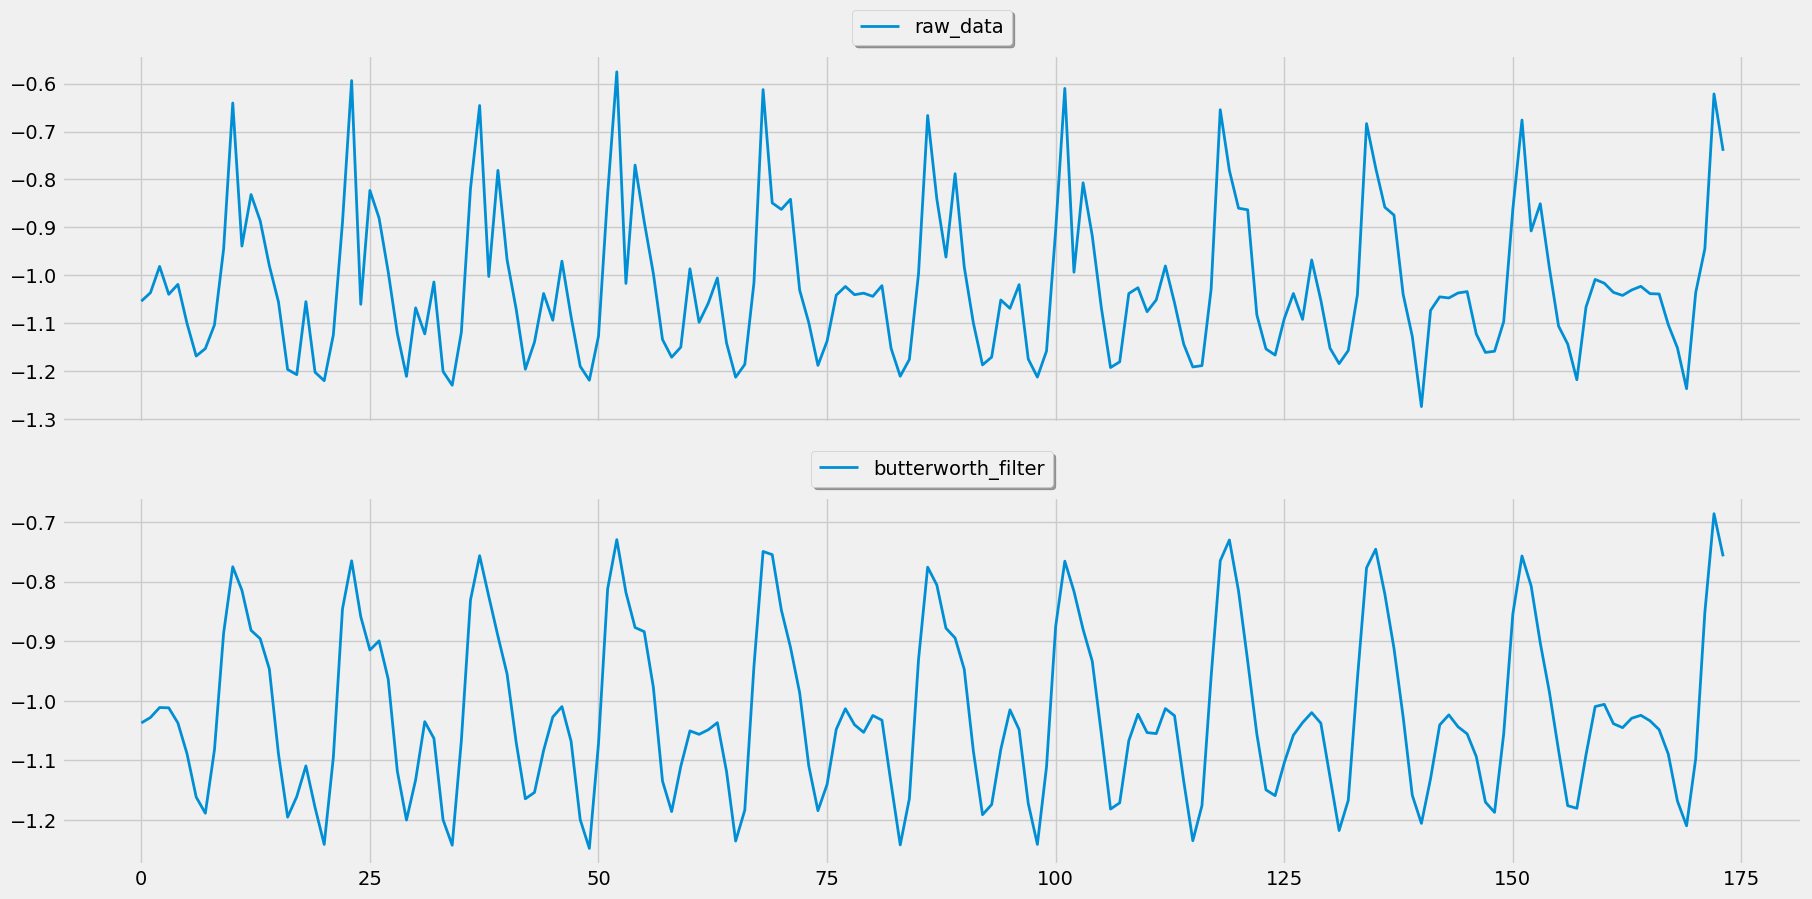

In [17]:
LowPass = LowPassFilter()
fs = 1000 / 200
cutoff = 1.3
df_lowpass = LowPass.low_pass_filter(df_lowpass,'acc_y',fs,cutoff,order= 5)

subset = df_lowpass[df_lowpass['set']==45]
print(subset['label'][0])

fig , ax = plt.subplots(nrows = 2 , sharex = True , figsize = (20,10))
ax[0].plot(subset['acc_y'].reset_index(drop = True),label= 'raw_data')
ax[1].plot(subset['acc_y_lowpass'].reset_index(drop = True),label= 'butterworth_filter')
ax[0].legend(loc = 'upper center',bbox_to_anchor = (0.5 , 1.15),fancybox = True , shadow = True)
ax[1].legend(loc = 'upper center',bbox_to_anchor = (0.5 , 1.15),fancybox = True , shadow = True)

In [19]:
for col in  predictor_columns:
  df_lowpass = LowPass.low_pass_filter(df_lowpass,col,fs,cutoff,order= 5)
  df_lowpass[col] = df_lowpass[col + '_lowpass']
  del df_lowpass[col + '_lowpass']

In [20]:
df_lowpass

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,duration
epoch (ms),,,,,,,,,,,
2019-01-11 15:08:05.200,0.013503,0.977003,-0.071001,-1.886218,2.438803,0.937522,B,bench,heavy,71,16.0
2019-01-11 15:08:05.400,0.008515,0.973169,-0.066481,-0.367396,0.439794,0.178360,B,bench,heavy,71,16.0
2019-01-11 15:08:05.600,-0.008450,0.966879,-0.071895,4.320608,-2.083978,-1.217263,B,bench,heavy,71,16.0


# Principal component analysis PCA

Text(0, 0.5, 'explained varience ')

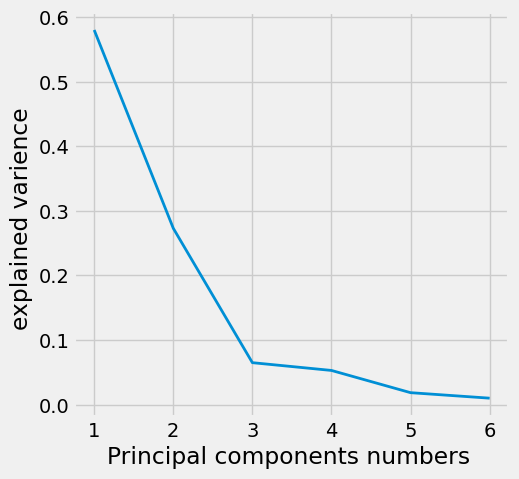

In [24]:
df_pca = df_lowpass.copy()
PCA = PrincipalComponentAnalysis()

pc_values = PCA.determine_pc_explained_variance(df_pca , predictor_columns)

plt.figure(figsize=(5,5))
plt.plot(range(1,len(predictor_columns )+1), pc_values)
plt.xlabel('Principal components numbers ')
plt.ylabel('explained varience ')

In [25]:
df_pca = PCA.apply_pca(df_pca , predictor_columns,3)

In [27]:
df_pca.head(2)

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,duration,pca_1,pca_2,pca_3
epoch (ms),,,,,,,,,,,,,,
2019-01-11 15:08:05.200,0.013503,0.977003,-0.071001,-1.886218,2.438803,0.937522,B,bench,heavy,71,16.0,-0.315889,-0.075461,0.072243
2019-01-11 15:08:05.400,0.008515,0.973169,-0.066481,-0.367396,0.439794,0.178360,B,bench,heavy,71,16.0,-0.314873,-0.073888,0.069825


<Axes: xlabel='epoch (ms)'>

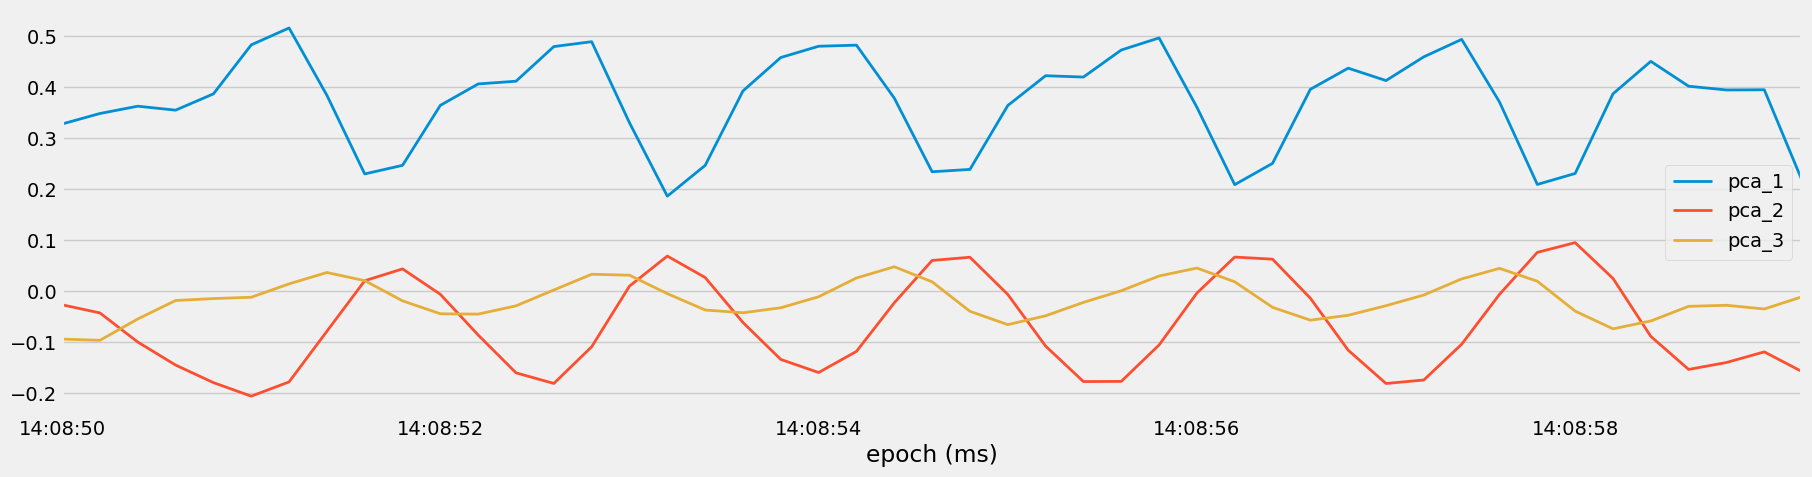

In [43]:
subset = df_pca[df_pca['set']==37]
subset[['pca_1','pca_2','pca_3']].plot()


# Sum of squares attributes

In [46]:
df_squared = df_pca.copy()

In [48]:
acc_r = df_squared['acc_x']**2  +  df_squared['acc_y']**2  + df_squared['acc_z']**2
gyr_r = df_squared['gyr_x']**2  +  df_squared['gyr_y']**2  + df_squared['gyr_z']**2
df_squared['acc_r'] = np.sqrt(acc_r)
df_squared['gyr_r'] = np.sqrt(gyr_r)

array([<Axes: xlabel='epoch (ms)'>, <Axes: xlabel='epoch (ms)'>],
      dtype=object)

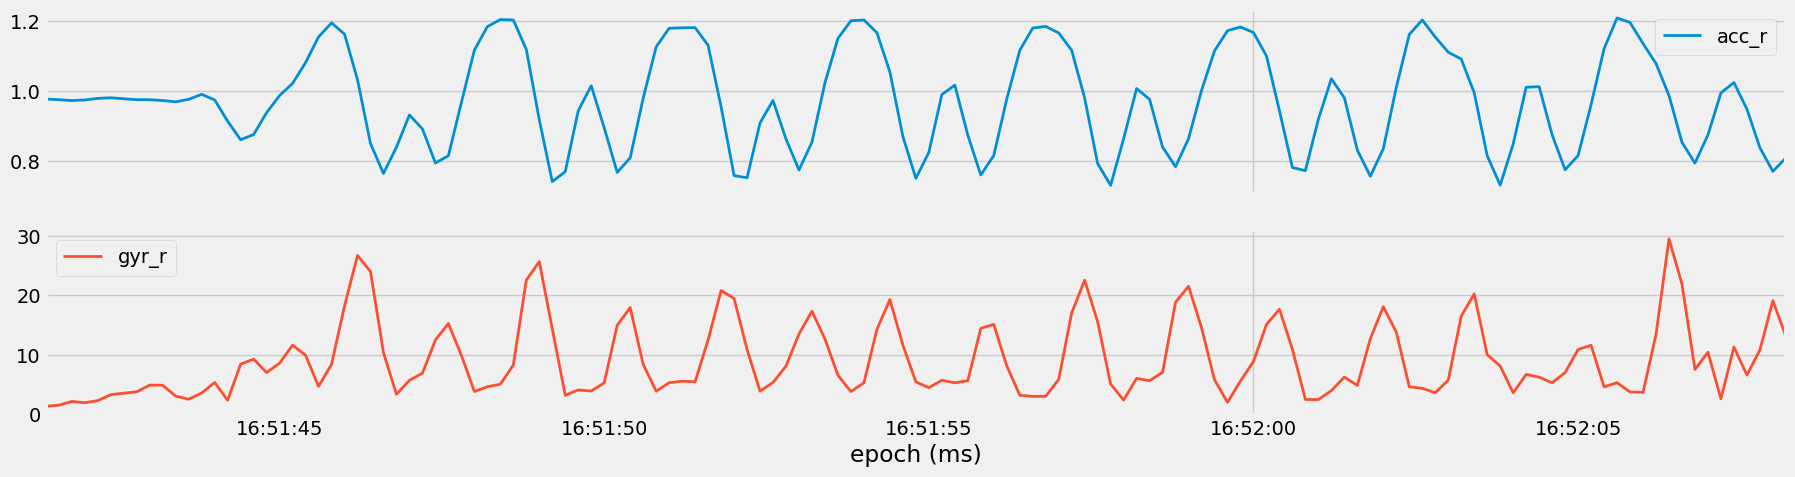

In [50]:
subset = df_squared[df_squared['set']==14]
subset[['acc_r','gyr_r']].plot(subplots = True)


In [127]:

# --------------------------------------------------------------
# Load data
# --------------------------------------------------------------


# --------------------------------------------------------------
# Dealing with missing values (imputation)
# --------------------------------------------------------------


# --------------------------------------------------------------
# Calculating set duration
# --------------------------------------------------------------


# --------------------------------------------------------------
# Butterworth lowpass filter
# --------------------------------------------------------------


# --------------------------------------------------------------
# Principal component analysis PCA
# --------------------------------------------------------------


# --------------------------------------------------------------
# Sum of squares attributes
# --------------------------------------------------------------


# --------------------------------------------------------------
# Temporal abstraction
# --------------------------------------------------------------


# --------------------------------------------------------------
# Frequency features
# --------------------------------------------------------------


# --------------------------------------------------------------
# Dealing with overlapping windows
# --------------------------------------------------------------


# --------------------------------------------------------------
# Clustering
# --------------------------------------------------------------


# --------------------------------------------------------------
# Export dataset
# --------------------------------------------------------------